In [112]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import plotly.graph_objects as go

from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [3]:
db = global_connect()

Select all drivers in itineraries that at least finished one itinerary

In [32]:
df_itdr = careful_query("SELECT DISTINCT(driver_id) FROM itineraries WHERE status='finished'")

In [90]:
df_itdr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2661 entries, 0 to 2660
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   driver_id  2661 non-null   object
dtypes: object(1)
memory usage: 20.9+ KB


In [93]:
careful_query("SELECT DISTINCT(driver_id) FROM itineraries").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   driver_id  2716 non-null   object
dtypes: object(1)
memory usage: 21.4+ KB


Number of drivers that never finished an itinerary: 2717 - 2661 = 56 (we shoud investigate them later)  
Now let's see one driver that has finished something

In [94]:
df_itdr.head()

,driver_id
0,eb271ab2ce67cf017d159cf66a69ba84
1,5408f7b12d5ce92ec0412efbeacfb59a
2,3d53e718a04640e25c111955567efd3d
3,0dca26b7239c1259f14b21c8b86555b7
4,2a0112c852363524351f806318558f8b


We will choose the first in list. Now let's obtain his availability data

In [95]:
df_av = careful_query("""
SELECT *
FROM availabilities
WHERE driver_id = 'eb271ab2ce67cf017d159cf66a69ba84';
""")
df_av.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   distribution_center  4622 non-null   int64         
 1   id                   4622 non-null   object        
 2   driver_id            4622 non-null   object        
 3   itinerary_id         915 non-null    object        
 4   lat                  4622 non-null   float64       
 5   lng                  4622 non-null   float64       
 6   sent                 4622 non-null   datetime64[ns]
 7   transport_type       4622 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 289.0+ KB


There are 4622 rows with this driver information. In 915 of them the driver was working over some itineraries.  
Now I am trying to see his itineraries moves

In [97]:
df_av.itinerary_id.nunique()

171

Of this uniques one of them is None, meaning that he was just available to receive assignations.  
There are many unique itineraries. Too much information to see on a map. Let's start by filtering some period

In [98]:
df_av.set_index('sent', inplace=True)

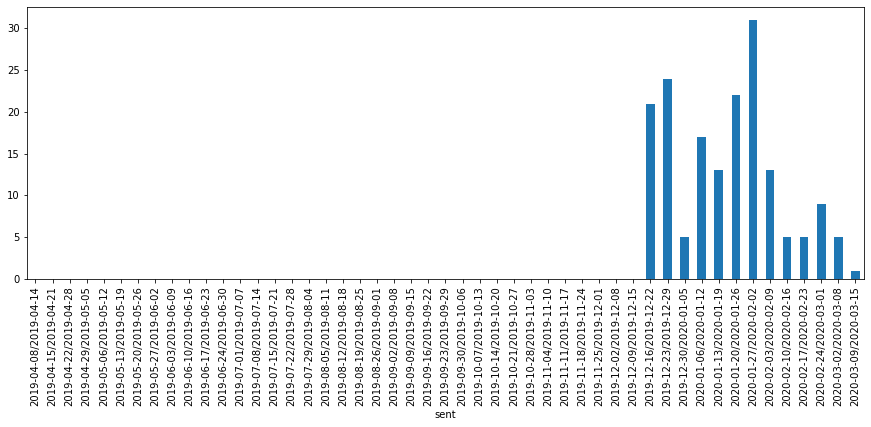

In [99]:
df_av.groupby(df_av.index.to_period('W'))['itinerary_id'].nunique().plot.bar(figsize=(15,5))
plt.xticks(rotation=90);

We are going to select the week from 2019-12-16 to 2019-12-22 inclusive

In [108]:
df_selection = df_av[(df_av.index >= '2019-12-16') & (df_av.index < '2019-12-23')]

In [160]:
# Where do we want to locate the map center?
use_selection_center = True

if use_selection_center:
    # center at our locations average
    longitude = df_selection['lng'].values.mean()
    latitude = df_selection['lat'].values.mean()
else:
    # center at San Pablo, Brazil
    latitude = -23.5475006
    longitude = -46.6361084

In [161]:
# Reference for mapbox layers
# https://plotly.com/python/mapbox-layers/

# Reference for scattermapbox (how to show text)
# https://plotly.com/python/reference/#scattermapbox

In [164]:
#all_map_styles = ["white-bg", "open-street-map", "carto-positron", "carto-darkmatter",
#                  "stamen-terrain", "stamen-toner", "stamen-watercolor"]

In [165]:
fig = go.Figure()

for itinerary, g in df_selection.groupby('itinerary_id'):

    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = g['lng'].values,
        lat = g['lat'].values,
        name = itinerary,
        text = g.reset_index().sent,
        marker = {'size': 10}))

# test this for auto centering:
fig.update_geos(fitbounds="locations")

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': longitude, 'lat': latitude},
        'style': "carto-positron",
        'zoom': 12})

fig.show()